In [2]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.signal import butter, filtfilt, hilbert
    SCIPY_OK = True
except Exception as e:
    SCIPY_OK = False
    print("scipy 없음")

In [3]:
Fs = 10_000     # sampling frequency (Hz)
T = 2.0         # signal duration (s)
t = np.arange(int(Fs * T)) / Fs

rpm = 1800      # shaft speed (RPM)
fm = rpm / 60   # 회전 주파수(변조 주파수) (Hz)
Z = 24          # 치수(geer teeth)
fc = Z * fm     # GMF (Hz)

m_depth = 0.5   # 변조 깊이
A_car = 1.0     # 캐리어(=GMF) 기본 진폭

harmonics = [1, 2, 3]       # GMF의 고조파(1*fc, 2*fc, 3*fc)
harm_amp = [1.0, 0.35, 0.18]        # 각 고조파 진폭
noise_std = 0.05            # 백색잡음 표준편차

# 측대역 생성

In [4]:
am = (1.0 + m_depth * np.cos(2 * np.pi * fm * t))

x = np.zeros_like(t)

for k, ak in zip(harmonics, harm_amp):
    x += ak * am * np.sin(2 * np.pi * (k * fc) * t)

x += noise_std * np.random.randn(len(t))

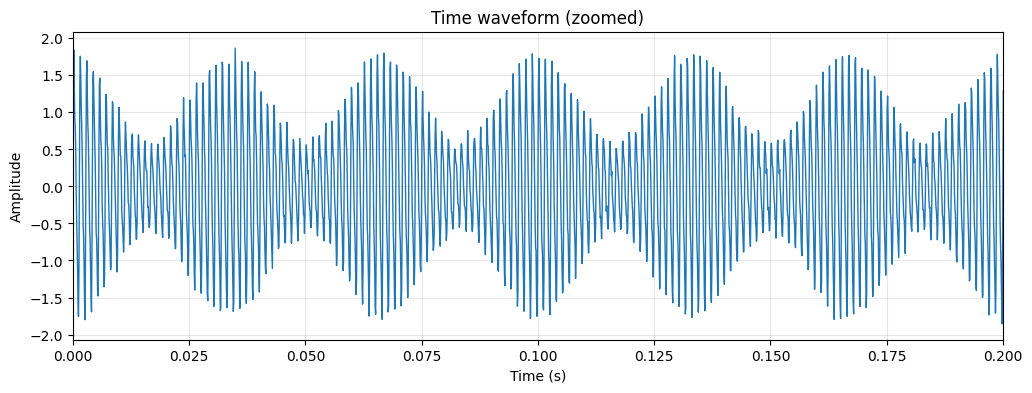

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(t, x, linewidth=1)
plt.xlim(0, 0.2)
plt.title("Time waveform (zoomed)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
def rfft_spectrum(x, Fs, window="hann"):
    N = len(x)

    if window == "hann":
        w = np.hanning(N)
    else:
        w = np.ones(N)

    xw = x * w
    X = np.fft.rfft(xw)
    f = np.fft.rfftfreq(N, d = 1 / Fs)

    mag = np.abs(X) / (np.sum(w) / 2)

    return f, mag

In [8]:
f, mag = rfft_spectrum(x, Fs, window="hann")
mag_db = 20 * np.log10(mag + 1e-12)

N_side = 6

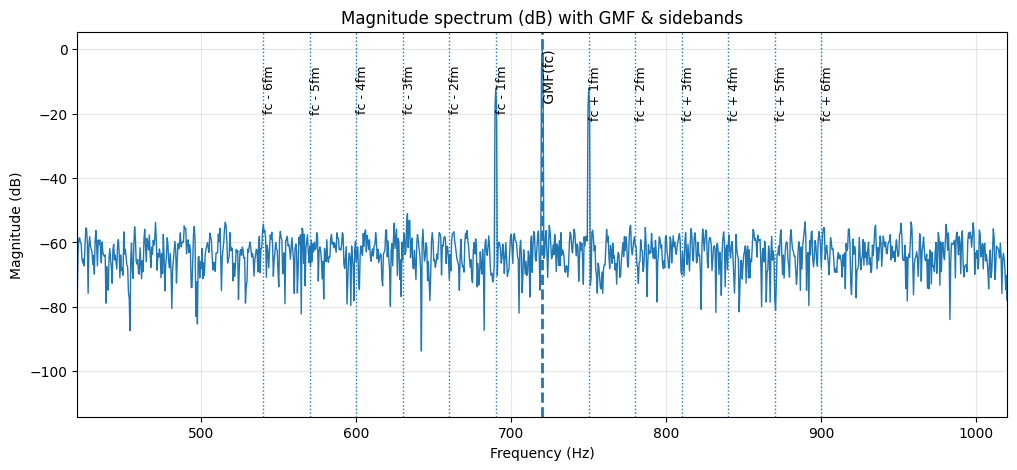

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(f, mag_db, linewidth=1)
plt.title("Magnitude spectrum (dB) with GMF & sidebands")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True, alpha=0.3)

# 관심 대역
span = 10 * fm      # 좌/우로 10 * fm 정도
plt.xlim(max(0, fc - span), fc + span)

plt.axvline(fc, linestyle="--", linewidth=2)
plt.text(fc, np.max(mag_db), " GMF(fc)", rotation=90, va="top")

for n in range(1, N_side + 1):
    f1 = fc - n * fm
    f2 = fc + n * fm

    if f1 > 0:
        plt.axvline(f1, linestyle=":", linewidth=1)
        plt.text(f1, np.max(mag_db) - 5, f" fc - {n}fm", rotation=90, va="top", fontsize=9)
    plt.axvline(f2, linestyle=":", linewidth=1)
    plt.text(f2, np.max(mag_db) - 5, f" fc + {n}fm", rotation=90, va="top", fontsize=9)

plt.show()